# ECON895 Project II

## Part One:
Add a tournament feature to the market module.  A tournament should allow two buyer/seller strategies to compete in a series of markets to see which strategy produces the maximum surplus for its owner.  You can read about one such tournament in the papers by Rust et. al.

## Part Two:
Implement at least three buyer/seller startegies, other than the ZI strategy that came with market, from the strategies discussed in the readings.  Run the strategies in your tournament and see which strategy does the best.  Do you think this will depend on the environment, i.e., the nature of the supply and demand curves chosen for the tournament?

## Part Three:
Build a Tkinter GUI where people can submit strategies and see the results of the tournament.  

# Part One:

Located in the main GitHub folder is a module titled `tournament.py`.

This tournament module allows for multiple buyer/seller strategies to compete in a series of market simulations. The `market_simulator_v2` loads the TOML config file before tournament runs multiple rounds to evaluate the strategies of each market particpant.

Here is example code below for calling the module:


{'name': 'B1', 'type': 'B', 'num_units': 3, 'min_value': 200, 'max_value': 400, 'trader_type': 'Zero Intelligence'}
{'name': 'B2', 'type': 'B', 'num_units': 3, 'min_value': 200, 'max_value': 400, 'trader_type': 'Kaplan'}
{'name': 'S1', 'type': 'S', 'num_units': 3, 'min_value': 100, 'max_value': 300, 'trader_type': 'Zero Intelligence'}
{'name': 'S2', 'type': 'S', 'num_units': 3, 'min_value': 100, 'max_value': 300, 'trader_type': 'Kaplan'}
B1: Average Surplus = 255.25
B2: Average Surplus = 145.82
S1: Average Surplus = 61.73
S2: Average Surplus = 108.60
Median Actual Surplus: 570.0
Mean Actual Surplus: 571.3922
Median Efficiency: 88.69899523906884
Mean Efficiency: 86.86964656190572


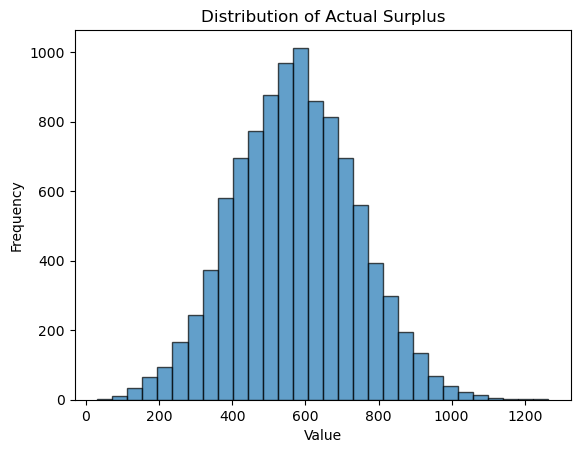

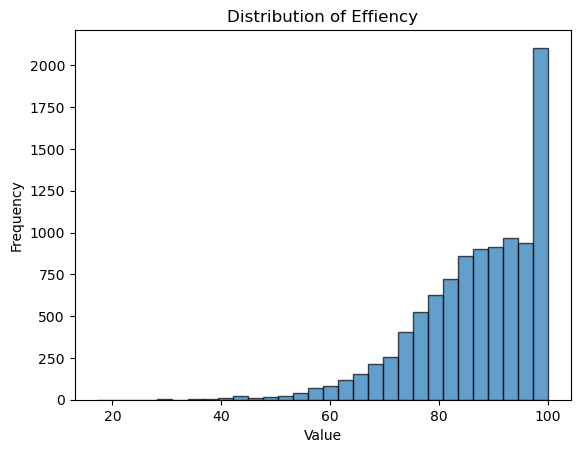

In [1]:
import market_simulator_v2 as msim
import tournament as tourn

rounds = 10000
sim_periods = 100

file_path = 'config files//config_test_ZI_Kaplan_Race.toml'
msimi = msim.MarketSim()
msimi.load_config(file_path)

sim = tourn.Tournament("tournament_name", rounds, sim_periods, file_path)
sim.eval_tournament()

# Part Two:

Implement at least three buyer/seller startegies, other than the ZI strategy that came with market, from the strategies discussed in the readings.  Run the strategies in your tournament and see which strategy does the best.  Do you think this will depend on the environment, i.e., the nature of the supply and demand curves chosen for the tournament?

## Strategies Added

The strategies added are also appropriately located in their respective `buyer` and `seller` modules.

### Kaplan

- Reading Source: Modeled after the 'Kaplan' bidding strategy in Rust et al. (1994, p. 73)
- Short Description: The strategy is to wait and let others exchange, but when the spread gets sufficiently close, jump in to "steal the deal"
- CODE:
```python
class Kaplan_Buyer:
    """
    A Buyer who can bid in a Double Auction Spot Market.
    Modeled after Kaplan's bidding strategy in Rust et al. (1994)
    """
    def __init__(self, name, reservation_values):
        self.name = name
        self.type = 'B'
        self.values = ReservationValues(name, reservation_values)
        self.prices = []
        self.contracts = []

    def __repr__(self):
        return f"{self.type}--{self.name} {self.values.reservation_values} current unit = {self.values.current_unit}"
        
    def bid(self, standing_bid, standing_ask, num_round, total_rounds):
        """
        Kaplan's bidding strategy as outline in Rust et al. (1994) p. 73
        """
        try:
            next_token = self.values.reservation_values[self.values.current_unit + 1]
        except IndexError:
            next_token = self.values.current
        
        if self.values.current == None:
            return None
        if standing_bid:
            if standing_ask:
                most = min(standing_ask, next_token - 1)
                if most > standing_bid:
                    if standing_ask <= 999 and ((self.values.current - standing_bid)/self.values.current) > 0.02 and (standing_ask - standing_bid) < (0.1 * standing_ask):
                        return self.name, "bid", min(standing_ask, most)
                    elif standing_ask <= 0:
                        return self.name, "bid", min(standing_ask, most)
                    elif (1 - (num_round / total_rounds)) <= 0.1:
                        return self.name, "bid", min(standing_ask, most)
                    else:
                        return None
                else:
                    return None
            else:
                most = next_token - 1
                if most > standing_bid:
                    if standing_ask <= 999 and ((self.values.current - standing_bid)/self.values.current) > 0.02 and (standing_ask - standing_bid) < (0.1 * standing_ask):
                        return self.name, "bid", min(standing_ask, most)
                    elif standing_ask <= 0:
                        return self.name, "bid", min(standing_ask, most)
                    elif (1 - (num_round / total_rounds)) <= 0.1:
                        return self.name, "bid", min(standing_ask, most)
                    else:
                        return None
                else:
                    return None
        else:
            return self.name, "bid", 1

    def contract(self, price, your_contract):
        """
        Buyer becomes informed about contract prices from Double Auction.
        Buyer must be registered with Double Auction to get price information.
        If your_contract == True buyer learns they have a contract at price.
        If your_contract == True buyer updates their current_unit.
        """
        self.prices.append(price)
        if your_contract:
            self.contracts.append(price)
            self.values.current_unit += 1     

class Kaplan_Seller:
    """
    A Buyer who can bid in a Double Auction Spot Market.
    Modeled after Kaplan's bidding strategy in Rust et al. (1994)
    """
    def __init__(self, name, unit_costs):
        self.name = name
        self.type = 'S'
        self.costs = UnitCosts(name, unit_costs)
        self.prices = []
        self.contracts = []

    def __repr__(self):
        return f"{self.type}--{self.name} {self.costs.unit_costs} current unit = {self.costs.current_unit}"
        
    def ask(self, standing_bid, standing_ask, num_round, total_rounds):
        """
        Kaplan's bidding strategy as outline in Rust et al. (1994) p. 73
        """
        try:
            next_token = self.costs.unit_costs[self.costs.current_unit + 1]
        except IndexError:
            next_token = self.costs.current

        if self.costs.current == None:
            return None
        if standing_ask:
            if standing_bid:
                least = max(standing_bid, next_token + 1)
                if least < standing_ask:
                    if standing_bid >= 999 and ((standing_ask - self.costs.current)/self.costs.current) > 0.02 and (standing_ask - standing_bid) < (0.1 * standing_bid):
                        return self.name, "ask", max(standing_bid, least)
                    elif standing_bid >= 0:
                        return self.name, "ask", max(standing_bid, least)
                    elif (1 - (num_round / total_rounds)) <= 0.2:
                        return self.name, "ask", max(standing_bid, least)
                    else:
                        return None
                else:
                    return None
            else:
                least = next_token + 1
                if least < standing_ask:
                    if standing_bid >= 999 and ((standing_ask - self.costs.current)/self.costs.current) > 0.02 and (standing_ask - standing_bid) < (0.1 * standing_bid):
                        return self.name, "ask", max(standing_bid, least)
                    elif standing_bid >= 0:
                        return self.name, "ask", max(standing_bid, least)
                    elif (1 - (num_round / total_rounds)) <= 0.2:
                        return self.name, "ask", max(standing_bid, least)
                    else:
                        return None
                else:
                    return None
        else:
            return self.name, "ask", 1
        
    def contract(self, price, your_contract):
        """
        Seller becomes informed about contract prices from Double Auction.
        Seller must be registered with Double Auction to get price information.
        If your_contract == True seller learns they have a contract at price.
        If your_contract == True seller updates their current_unit.
        """
        self.prices.append(price)
        if your_contract:
            self.contracts.append(price)
            self.costs.current_unit += 1    
```
### Ringuette

- Reading Source: Modeled after the 'Ringuette' bidding strategy in Rust et al. (1994, p. 74).
- Short Description: Like the 'Kaplan' strategy, wait and let others exchange, but when the spread gets sufficiently close, jump in to "steal the deal."
- CODE:
```python
class Ringuette_Buyer:
    """
    A Buyer who can bid in a Double Auction Spot Market.
    Modeled after Ringuette's bidding strategy in Rust et al. (1994)
    """
    def __init__(self, name, reservation_values):
        self.name = name
        self.type = 'B'
        self.values = ReservationValues(name, reservation_values)
        self.prices = []
        self.contracts = []

    def __repr__(self):
        return f"{self.type}--{self.name} {self.values.reservation_values} current unit = {self.values.current_unit}"
    
    def bid(self, standing_bid, standing_ask, num_round, total_rounds):
        """ 
        """
        try:
            next_token = self.values.reservation_values[self.values.current_unit + 1]
        except IndexError:
            next_token = self.values.current

        if (1 - (num_round / total_rounds)) <= 0.1:
            skeleton = Skeleton_Buyer(self.name, self.values.reservation_values)
            skeleton.bid(standing_bid, standing_ask, num_round, total_rounds)
        else:
            span = (self.values.reservation_values[0] - self.values.reservation_values[-1] + 10)
            if standing_bid < (total_rounds/4):
                return self.name, "bid", standing_bid + 1
            elif standing_bid > (total_rounds/4):
                if standing_ask:
                    if (standing_bid - standing_ask) > (span/5) and (next_token) > (standing_ask + (span/5)):
                        return self.name, "bid", standing_ask + 1 + (0.05 * rnd.uniform(0,1) * span)
                    else:
                        return None
                else:
                    return None

    def contract(self, price, your_contract):
        """
        Buyer becomes informed about contract prices from Double Auction.
        Buyer must be registered with Double Auction to get price information.
        If your_contract == True buyer learns they have a contract at price.
        If your_contract == True buyer updates their current_unit.
        """
        self.prices.append(price)
        if your_contract:
            self.contracts.append(price)
            self.values.current_unit += 1

class Ringuette_Seller:
    """
    A Buyer who can bid in a Double Auction Spot Market.
    Modeled after Ringuette's bidding strategy in Rust et al. (1994)
    """
    def __init__(self, name, unit_costs):
        self.name = name
        self.type = 'S'
        self.costs = UnitCosts(name, unit_costs)
        self.prices = []
        self.contracts = []

    def __repr__(self):
        return f"{self.type}--{self.name} {self.costs.unit_costs} current unit = {self.costs.current_unit}"
        
    def ask(self, standing_bid, standing_ask, num_round, total_rounds):
        """ 
        """
        try:
            next_token = self.costs.unit_costs[self.costs.current_unit + 1]
        except IndexError:
            next_token = self.costs.current
        
        if (1 - (num_round / total_rounds)) <= 0.2:
            skeleton = Skeleton_Seller(self.name, self.costs.unit_costs)
            skeleton.ask(standing_bid, standing_ask, num_round, total_rounds)
        else:
            span = (self.costs.unit_costs[-1] - self.costs.unit_costs[0] + 10)
            if standing_ask > (total_rounds/4):
                return self.name, "ask", standing_ask - 1
            else:
                if standing_bid:
                    if (standing_ask - standing_bid) > (span/5) and next_token < (standing_bid - (span/5)):
                        return self.name, "ask", standing_bid - 1 - (0.05 * rnd.uniform(0,1) * span)
                    else:
                        return None
                else:
                    return None

    def contract(self, price, your_contract):
        """
        Buyer becomes informed about contract prices from Double Auction.
        Buyer must be registered with Double Auction to get price information.
        If your_contract == True buyer learns they have a contract at price.
        If your_contract == True buyer updates their current_unit.
        """
        self.prices.append(price)
        if your_contract:
            self.contracts.append(price)
            self.costs.current_unit += 1
```
### Persistent Shout
- Reading Source: Modeled after the 'Persistent Shout' bidding strategy in Priest & Tol (2003).
- Short Description: The strategy is to be extremely competitive when bids/asks are not taking place and only target a little bit higher than the best price when trades are taking place. Target is moved toward at a "learning rate" and "momentum" rate.
- CODE:
```python
class PS_Buyer:
    """
    A Buyer who can bid in a Double Auction Spot Market.
    Modeled after the 'Persistent Shout' bidding strategy in Priest & Tol (2003)
    """
    def __init__(self, name, reservation_values):
        self.name = name
        self.type = 'B'
        self.values = ReservationValues(name, reservation_values)
        self.prices = []
        self.contracts = []

    def __repr__(self):
        return f"{self.type}--{self.name} {self.values.reservation_values} current unit = {self.values.current_unit}"
    
    def bid(self, standing_bid, standing_ask, num_round, total_rounds):
        try:
            next_token = self.values.reservation_values[self.values.current_unit + 1]
        except IndexError:
            next_token = self.values.current
        
        if self.values.current == None:
            return None

        r_1 = rnd.uniform(0,0.2)
        r_2 = rnd.uniform(0,0.2)
        gamma = 0.5
        beta = 0.1

        if standing_ask > standing_bid:
            delta = (r_1 * standing_bid) + r_2
            target = standing_bid + delta
            potential_bid = gamma * self.values.current + (1 - gamma) * beta * (target - self.values.current)
            if potential_bid <= self.values.current:
                return self.name, "bid", potential_bid
            else:
                return None
        elif standing_ask <= standing_bid:
            delta = (r_1 * standing_ask) + r_2
            target = standing_ask - delta
            potential_bid = gamma * self.values.current + (1 - gamma) * beta * (target - self.values.current)
            if potential_bid <= self.values.current:
                return self.name, "bid", potential_bid
            else:
                return None

    def contract(self, price, your_contract):
        """
        Buyer becomes informed about contract prices from Double Auction.
        Buyer must be registered with Double Auction to get price information.
        If your_contract == True buyer learns they have a contract at price.
        If your_contract == True buyer updates their current_unit.
        """
        self.prices.append(price)
        if your_contract:
            self.contracts.append(price)
            self.values.current_unit += 1

class PS_Seller:
    """
    A Buyer who can bid in a Double Auction Spot Market.
    Modeled after the 'Persistent Shout' bidding strategy in Priest & Tol (2003)
    """
    def __init__(self, name, unit_costs):
        self.name = name
        self.type = 'S'
        self.costs = UnitCosts(name, unit_costs)
        self.prices = []
        self.contracts = []

    def __repr__(self):
        return f"{self.type}--{self.name} {self.costs.unit_costs} current unit = {self.costs.current_unit}"
    
    def ask(self, standing_bid, standing_ask, num_round, total_rounds):
        """ 
        """
        r_1 = rnd.uniform(0,0.2)
        r_2 = rnd.uniform(0,0.2)
        gamma = 0.3
        beta = 0.05

        if standing_ask > standing_bid:
            delta = r_1 * standing_ask + r_2
            target = standing_bid - delta
            
            potential_ask = gamma * self.costs.current + (1 - gamma) * beta * (target - self.costs.current)
            if potential_ask >= self.costs.current:
                return self.name, "ask", potential_ask
            else:
                return None
        elif standing_ask <= standing_bid:
            delta = r_1 * standing_bid + r_2
            target = standing_ask + delta

            potential_ask = gamma * self.costs.current + (1 - gamma) * beta * (target - self.costs.current)
            if potential_ask >= self.costs.current:
                return self.name, "ask", potential_ask
            else:
                return None

    def contract(self, price, your_contract):
        """
        Buyer becomes informed about contract prices from Double Auction.
        Buyer must be registered with Double Auction to get price information.
        If your_contract == True buyer learns they have a contract at price.
        If your_contract == True buyer updates their current_unit.
        """
        self.prices.append(price)
        if your_contract:
            self.contracts.append(price)
            self.costs.current_unit += 1
```
### Skeleton
- Reading Source: Modeled after the 'Skeleton' strategy bidding strategy in Rust et al. (1994, p. 75).
- Short Description: The base strategy provided by the authors was supplied to all entrants of a double auction tournament.
- CODE:
```python
class Skeleton_Buyer:
    def __init__(self, name, reservation_values):
        self.name = name
        self.type = 'B'
        self.values = ReservationValues(name, reservation_values)
        self.prices = []
        self.contracts = []

    def __repr__(self):
        return f"{self.type}--{self.name} {self.values.reservation_values} current unit = {self.values.current_unit}"
    
    def bid(self, standing_bid, standing_ask, num_round, total_rounds):
        try:
            next_token = self.values.reservation_values[self.values.current_unit + 1]
        except IndexError:
            next_token = self.values.current

        if self.values.current == None:
            return None

        alpha = 0.25 + 0.1 * rnd.uniform(0,1)
        if standing_bid:
            if standing_ask:
                most = min(standing_ask, next_token - 1)
                if most <= standing_bid:
                    return None
                else:
                    return self.name, "bid", (1 - alpha) * (standing_bid + 1) + alpha * most
            else:
                most = next_token - 1
                if most <= standing_bid:
                    return None
                else:
                    return self.name, "bid", (1 - alpha) * (standing_bid + 1) + alpha * most
        else:
            if standing_ask:
                most = min(standing_ask, self.values.reservation_values[-1] - 1)
                return self.name, "bid", most - (alpha * (self.values.reservation_values[0] - self.values.reservation_values[-1]))
            else:
                most = self.values.reservation_values[-1] - 1
                return self.name, "bid", most - (alpha * (self.values.reservation_values[0] - self.values.reservation_values[-1]))

    def contract(self, price, your_contract):
        """
        Buyer becomes informed about contract prices from Double Auction.
        Buyer must be registered with Double Auction to get price information.
        If your_contract == True buyer learns they have a contract at price.
        If your_contract == True buyer updates their current_unit.
        """
        self.prices.append(price)
        if your_contract:
            self.contracts.append(price)
            self.values.current_unit += 1

class Skeleton_Seller:
    def __init__(self, name, unit_costs):
        self.name = name
        self.type = 'S'
        self.costs = UnitCosts(name, unit_costs)
        self.prices = []
        self.contracts = []

    def __repr__(self):
        return f"{self.type}--{self.name} {self.costs.unit_costs} current unit = {self.costs.current_unit}"
    
    def ask(self, standing_bid, standing_ask, num_round, total_rounds):
        try:
            next_token = self.costs.unit_costs[self.costs.current_unit + 1]
        except IndexError:
            next_token = self.costs.current

        if self.costs.current == None:
            return None

        alpha = 0.25 + 0.1 * rnd.uniform(0,1)
        if standing_ask:
            if standing_bid:
                most = max(standing_bid, next_token + 1)
                if most >= standing_ask:
                    return None
                else:
                    return self.name, "ask", (1 - alpha) * (standing_ask - 1) + alpha * most
            else:
                most = next_token + 1
                if most >= standing_bid:
                    return None
                else:
                    return self.name, "ask", (1 - alpha) * (standing_ask - 1) + alpha * most
        else:
            if standing_bid:
                most = max(standing_bid, self.costs.unit_costs[0] + 1)
                return self.name, "ask", most + (alpha * (self.costs.unit_costs[-1] - self.costs.unit_costs[0]))
            else:
                most = self.costs.unit_costs[0] + 1
                return self.name, "ask", most + (alpha * (self.costs.unit_costs[-1] - self.costs.unit_costs[0]))

    def contract(self, price, your_contract):
        """
        Buyer becomes informed about contract prices from Double Auction.
        Buyer must be registered with Double Auction to get price information.
        If your_contract == True buyer learns they have a contract at price.
        If your_contract == True buyer updates their current_unit.
        """
        self.prices.append(price)
        if your_contract:
            self.contracts.append(price)
            self.costs.current_unit += 1
```
## Tournament Results

### Horse Race


{'name': 'B1', 'type': 'B', 'num_units': 3, 'min_value': 200, 'max_value': 400, 'trader_type': 'Zero Intelligence'}
{'name': 'B2', 'type': 'B', 'num_units': 3, 'min_value': 200, 'max_value': 400, 'trader_type': 'Kaplan'}
{'name': 'B3', 'type': 'B', 'num_units': 3, 'min_value': 200, 'max_value': 400, 'trader_type': 'Persistent Shout'}
{'name': 'B4', 'type': 'B', 'num_units': 3, 'min_value': 200, 'max_value': 400, 'trader_type': 'Skeleton'}
{'name': 'B5', 'type': 'B', 'num_units': 3, 'min_value': 200, 'max_value': 400, 'trader_type': 'Ringuette'}
{'name': 'S1', 'type': 'S', 'num_units': 3, 'min_value': 100, 'max_value': 300, 'trader_type': 'Zero Intelligence'}
{'name': 'S2', 'type': 'S', 'num_units': 3, 'min_value': 100, 'max_value': 300, 'trader_type': 'Kaplan'}
{'name': 'S3', 'type': 'S', 'num_units': 3, 'min_value': 100, 'max_value': 300, 'trader_type': 'Persistent Shout'}
{'name': 'S4', 'type': 'S', 'num_units': 3, 'min_value': 100, 'max_value': 300, 'trader_type': 'Skeleton'}
{'nam

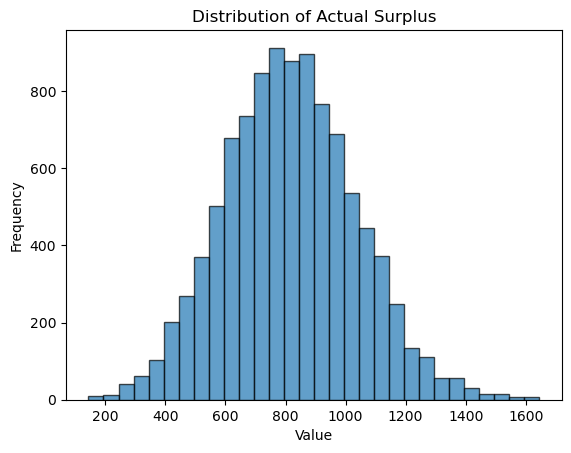

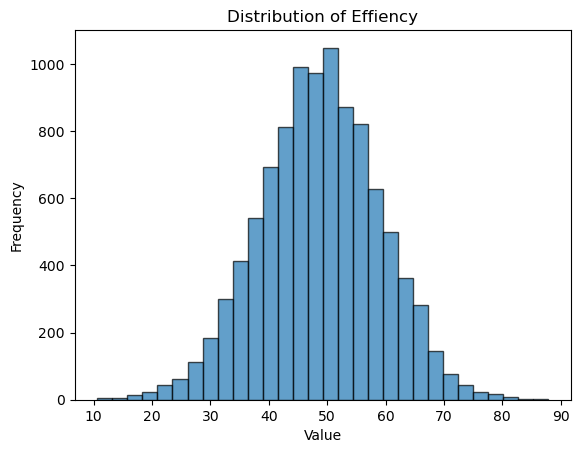

In [4]:
import market_simulator_v2 as msim
import tournament as tourn


rounds = 10000
sim_periods = 100

file_path = 'config files//config_test_HorseRace.toml'
msimi = msim.MarketSim()
msimi.load_config(file_path)

sim = tourn.Tournament("tournament_name", rounds, sim_periods, file_path)
sim.eval_tournament()

### Zero Intelligence vs. Kaplan

#### One Buyer, One Seller Each


{'name': 'B1', 'type': 'B', 'num_units': 3, 'min_value': 200, 'max_value': 400, 'trader_type': 'Zero Intelligence'}
{'name': 'B2', 'type': 'B', 'num_units': 3, 'min_value': 200, 'max_value': 400, 'trader_type': 'Kaplan'}
{'name': 'S1', 'type': 'S', 'num_units': 3, 'min_value': 100, 'max_value': 300, 'trader_type': 'Zero Intelligence'}
{'name': 'S2', 'type': 'S', 'num_units': 3, 'min_value': 100, 'max_value': 300, 'trader_type': 'Kaplan'}
B1: Average Surplus = 256.14
B2: Average Surplus = 146.43
S1: Average Surplus = 62.55
S2: Average Surplus = 108.98
Median Actual Surplus: 573.0
Mean Actual Surplus: 574.0937
Median Efficiency: 88.94473075678535
Mean Efficiency: 86.93912330098789


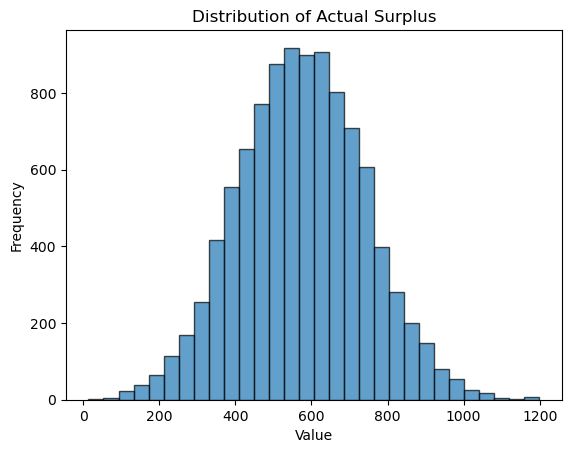

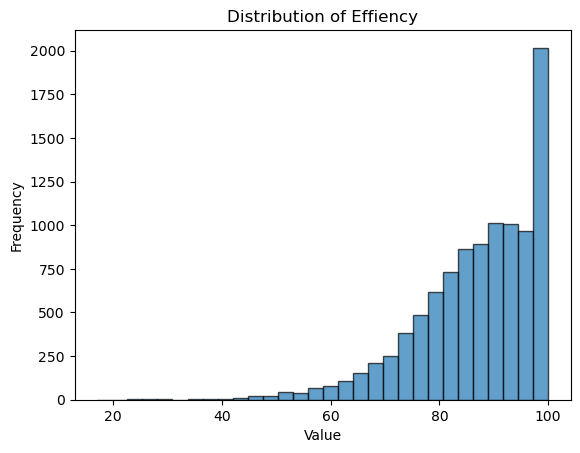

In [8]:
import market_simulator_v2 as msim
import tournament as tourn


rounds = 10000
sim_periods = 100

file_path = 'config files//config_test_ZI_Kaplan_Race.toml'
msimi = msim.MarketSim()
msimi.load_config(file_path)

sim = tourn.Tournament("tournament_name", rounds, sim_periods, file_path)
sim.eval_tournament()

#### All Buyers (Zero Intelligence) v. All Sellers (Kaplan)


{'name': 'B1', 'type': 'B', 'num_units': 3, 'min_value': 200, 'max_value': 400, 'trader_type': 'Zero Intelligence'}
{'name': 'B2', 'type': 'B', 'num_units': 3, 'min_value': 200, 'max_value': 400, 'trader_type': 'Zero Intelligence'}
{'name': 'S1', 'type': 'S', 'num_units': 3, 'min_value': 100, 'max_value': 300, 'trader_type': 'Kaplan'}
{'name': 'S2', 'type': 'S', 'num_units': 3, 'min_value': 100, 'max_value': 300, 'trader_type': 'Kaplan'}
B1: Average Surplus = 180.49
B2: Average Surplus = 187.15
S1: Average Surplus = 135.20
S2: Average Surplus = 129.09
Median Actual Surplus: 630.5
Mean Actual Surplus: 631.929
Median Efficiency: 99.79874036093504
Mean Efficiency: 95.3383844375709


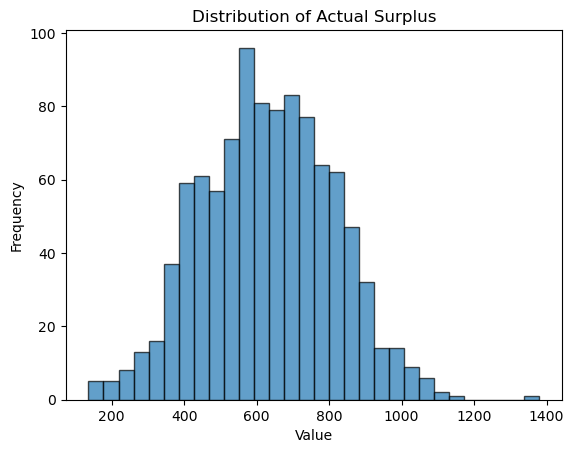

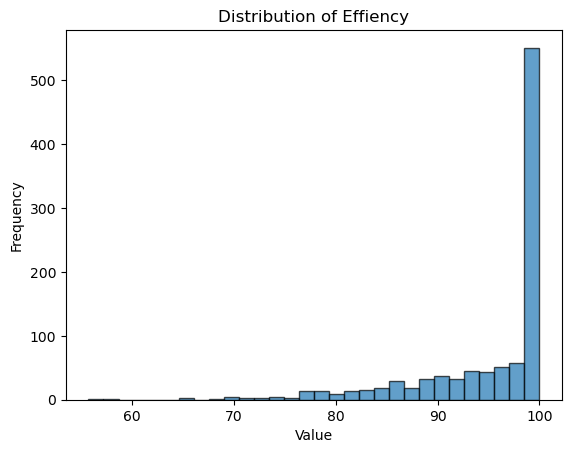

In [ ]:
import market_simulator_v2 as msim
import tournament as tourn


rounds = 10000
sim_periods = 100

file_path = 'config files//config_test_ZI_Kaplan_Race2.toml'
msimi = msim.MarketSim()
msimi.load_config(file_path)

sim = tourn.Tournament("tournament_name", rounds, sim_periods, file_path)
sim.eval_tournament()

#### All Buyers (Kaplan) v. All Sellers (Zero Intelligence)


{'name': 'B1', 'type': 'B', 'num_units': 3, 'min_value': 200, 'max_value': 400, 'trader_type': 'Kaplan'}
{'name': 'B2', 'type': 'B', 'num_units': 3, 'min_value': 200, 'max_value': 400, 'trader_type': 'Kaplan'}
{'name': 'S1', 'type': 'S', 'num_units': 3, 'min_value': 100, 'max_value': 300, 'trader_type': 'Zero Intelligence'}
{'name': 'S2', 'type': 'S', 'num_units': 3, 'min_value': 100, 'max_value': 300, 'trader_type': 'Zero Intelligence'}
B1: Average Surplus = 144.71
B2: Average Surplus = 140.20
S1: Average Surplus = 33.02
S2: Average Surplus = 31.93
Median Actual Surplus: 355.0
Mean Actual Surplus: 349.856
Median Efficiency: 55.01954518826224
Mean Efficiency: 53.75052306155648


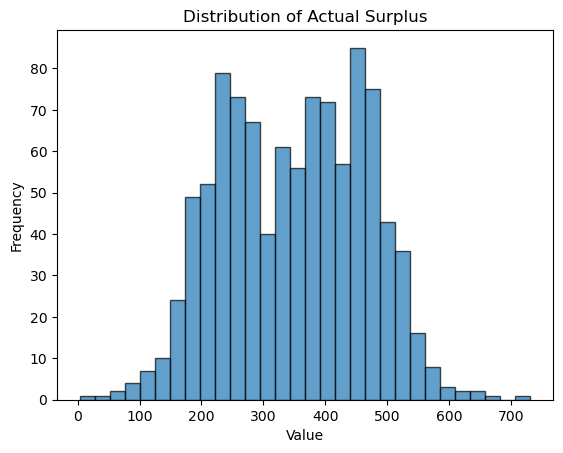

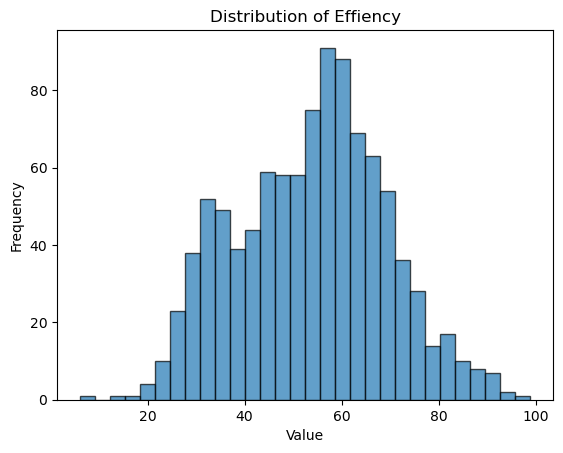

In [ ]:
import market_simulator_v2 as msim
import tournament as tourn


rounds = 10000
sim_periods = 100

file_path = 'config files//config_test_ZI_Kaplan_Race3.toml'
msimi = msim.MarketSim()
msimi.load_config(file_path)

sim = tourn.Tournament("tournament_name", rounds, sim_periods, file_path)
sim.eval_tournament()

## Tournament Analysis

Kaplan performs very well, it seems. The top two strategies, however, were Zero-Intelligence and Kaplan in the horse race. The next best after those two was Skeleton, then Persistent Shout, and then finally Ringuette. We can put the Zero-Intelligence and Kaplan strategies against each other in the tournament as **1)** *One Buyer, One Seller Each*; **2)** *All Buyers (Zero Intelligence) v. All Sellers (Kaplan)*; and **3)** *All Buyers (Kaplan) v. All Sellers (Zero Intelligence)*. In the first scenario, Zero Intelligence performs better; in the second scenario, both perform roughly the same; in the third scenario, both perform roughly the same. 

This project uses Leonid Hurwicz (1960) and (1972) as a framework for exploring double auctions. Hurwicz's framework consists of **1)** an environment and **2)** an institution. This project specifically states the environment as a spot market and a double auction as an institution. The spot market defines the buyers and sellers within it, the demand curve, and the supply curve, which is where the calculation of the competitive equilibrium can occur.

The environment should be the same for each type of buyer and seller so that only the bidding/selling strategy is changing. `spot_market_environment.py` should be essentially doing this by building reservation values and unit costs in the same fashion for given buyers or sellers. If the environment were to be manipulated to allow for changes in the demand and supply curves, then this should alter the results observed.

# Part Three:

Located in the main GitHub folder is a module titled `market_siim_api.py`.

This module allows for a Tkinter GUI to be used.

Here is example code below for calling the module:

In [8]:
import market_sim_api as gui

root = gui.tk.Tk()
market_sim = gui.sim.MarketSim()
sim_app = gui.MktSimGui(root, market_sim)
root.mainloop()
root.destroy()